In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import celerite as celery
import exoplanet as xo
np.random.seed(42)
%matplotlib inline

In [2]:
import pymc3 as pm
import theano.tensor as tt
from exoplanet.gp import terms, GP

In [3]:
d = np.genfromtxt('sim_oneyear_onemode.csv', names=True, dtype=None, delimiter=',')
ts_onemode = np.copy(d['ts'])
rvs_onemode = np.copy(d['rvs'])
xs_onemode = np.copy(d['xs'])

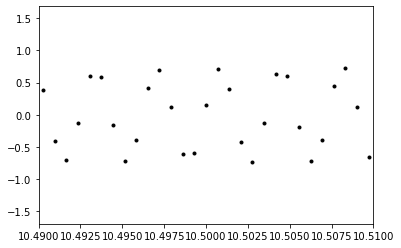

In [14]:
plt.plot(ts_onemode/86400., rvs_onemode, 'k.')
plt.xlim([10.49,10.51]);

In [31]:
inds = (ts_onemode > 10.49 * 86400) & (ts_onemode < 10.51 * 86400)
t = ts_onemode[inds]
y = rvs_onemode[inds]
yerr = np.zeros_like(y) + 0.1 # 10 cm/s homogeneous error - made up!
t_grid = np.linspace(t[0], t[-1], 0.01)
with pm.Model() as model:

    logS0 = pm.Normal("logS0", mu=0.0, sd=15.0, testval=np.log(np.var(rvs_onemode)))
    logw0 = pm.Normal("logw0", mu=-3.9, sd=2.0)
    logQ = pm.Normal("logQ", mu=8.1, sd=2.0)

    # Set up the kernel and GP
    kernel = terms.SHOTerm(log_S0=logS0, log_w0=logw0, log_Q=logQ)
    gp = GP(kernel, t, yerr ** 2)

    # Add a custom "potential" (log probability function) with the GP likelihood
    pm.Potential("gp", gp.log_likelihood(y))

with model:
    map_soln = xo.optimize(start=model.test_point)
    mu, var = xo.eval_in_model(gp.predict(t_grid, return_var=True), map_soln)

optimizing logp for variables: [logQ, logw0, logS0]
19it [00:00, 774.25it/s, logp=2.571935e+01] 
message: Optimization terminated successfully.
logp: 13.043173216224503 -> 25.71935218966477


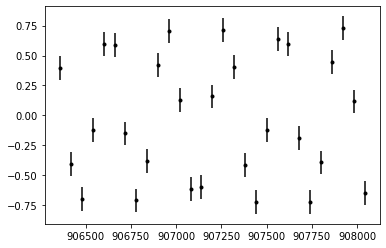

In [32]:
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label="data")

# Plot the prediction and the 1-sigma uncertainty
sd = np.sqrt(var)
art = plt.fill_between(t_grid, mu + sd, mu - sd, color="C1", alpha=0.3)
art.set_edgecolor("none")
plt.plot(t_grid, mu, color="C1", label="prediction");

In [33]:
map_soln

{'logS0': array(-6.43600347),
 'logw0': array(-3.92937863),
 'logQ': array(8.86969188)}

In [34]:
mu

array([], dtype=float64)